# Q5-Support Vector Machines (SVMs)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import copy
from sklearn.svm import SVC

path=r"C:\Unipi-CS\5ο εξάμηνο\Αναγνώριση Προτύπων\project\Data\original dataset\crimes.csv"

data=pd.read_csv(path)

In [42]:
categorical_features = ["weapon_code", "scene_type", "weather", "vic_gender"]
continuous_features = ["hour_float", "latitude", "longitude", "victim_age", "temp_c", "humidity", "dist_precinct_km", "pop_density"]

train_df = data[data["split"] == "TRAIN"]
val_df = data[data["split"] == "VAL"]

In [43]:
y_train = train_df["killer_id"].values
y_val_true = val_df["killer_id"].values

In [44]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), continuous_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
svm_clf = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('classifier', SVC(kernel='rbf', decision_function_shape='ovr',probability=True))])

In [45]:
c_values = [0.1, 1, 10]
best_acc = -1
best_svm = None

for c in c_values:
    svm_clf.set_params(classifier__C=c, classifier__gamma='scale')
    svm_clf.fit(train_df, y_train)
        
    preds = svm_clf.predict(val_df)
    acc = accuracy_score(y_val_true, preds)
    print(f"SVM (C={c}) -> VAL Accuracy: {acc:.4f}")
        
    if acc > best_acc:
        best_acc = acc
        best_svm = copy.deepcopy(svm_clf)

y_val_pred_svm = best_svm.predict(val_df)
acc_val_svm = accuracy_score(y_val_true, y_val_pred_svm)
print(f"\n--- SVM Results ---")
print(f"Best SVM VAL Accuracy: {acc_val_svm:.4f}")

SVM (C=0.1) -> VAL Accuracy: 0.8977
SVM (C=1) -> VAL Accuracy: 0.9468
SVM (C=10) -> VAL Accuracy: 0.9415

--- SVM Results ---
Best SVM VAL Accuracy: 0.9468


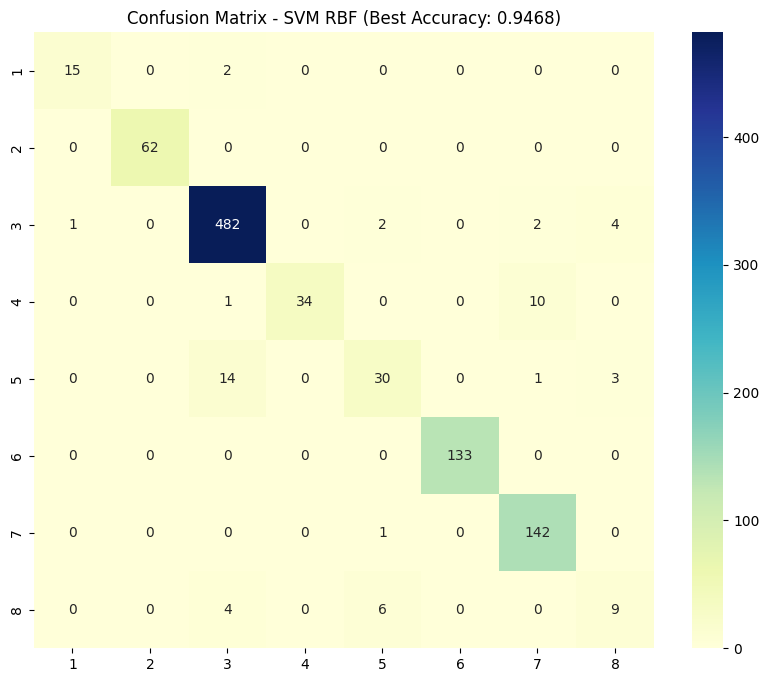

In [46]:
killers = np.unique(y_train)
cm_svm = confusion_matrix(y_val_true, y_val_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', xticklabels=killers, yticklabels=killers, cmap='YlGnBu')
plt.title(f'Confusion Matrix - SVM RBF (Best Accuracy: {best_acc:.4f})')
plt.show()

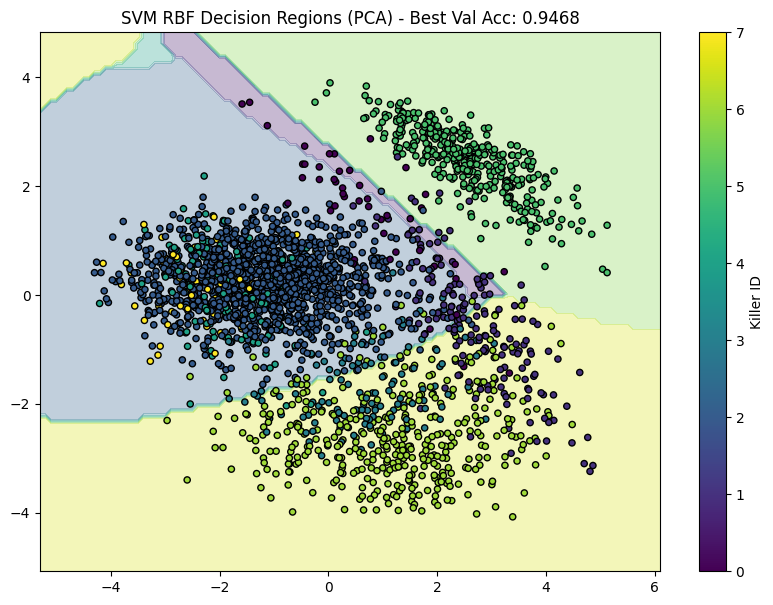

In [47]:
le = LabelEncoder()
le.fit(data["killer_id"].unique()) 

X_train_transformed = best_svm.named_steps['preprocessor'].transform(train_df)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_transformed)
    
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
grid_points_pca = np.c_[xx.ravel(), yy.ravel()]
grid_points_full = pca.inverse_transform(grid_points_pca)
    
Z_raw = best_svm.named_steps['classifier'].predict(grid_points_full)
Z = le.transform(Z_raw).reshape(xx.shape)
    
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=le.transform(y_train), edgecolor='k', s=20, cmap='viridis')
plt.title(f"SVM RBF Decision Regions (PCA) - Best Val Acc: {best_acc:.4f}")
plt.colorbar(label='Killer ID')
plt.show()

In [48]:
np.save(r"C:\Unipi-CS\5ο εξάμηνο\Αναγνώριση Προτύπων\project\Data\Data Manger\svm_results.npy",y_val_pred_svm)

In [49]:
full_train_df = data[data["split"].isin(["TRAIN", "VAL"])]
y_full = full_train_df["killer_id"].values
best_svm.fit(full_train_df, y_full)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['hour_float', 'latitude',
                                                   'longitude', 'victim_age',
                                                   'temp_c', 'humidity',
                                                   'dist_precinct_km',
                                                   'pop_density']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weapon_code', 'scene_type',
                                                   'weather',
                                                   'vic_gender'])])),
                ('classifier', SVC(C=1, probability=True))])

In [50]:
test_df = data[data["split"] == "TEST"]

pred = best_svm.predict(test_df)
proba = best_svm.predict_proba(test_df)  

classes = best_svm.named_steps["classifier"].classes_  

submission = pd.DataFrame({
    "incident_id": test_df["incident_id"],         
    "predicted_killer": pred
})

for j, k in enumerate(classes):
    submission[f"p_killer_{int(k)}"] = proba[:, j]

submission.to_csv(r"C:\Unipi-CS\5ο εξάμηνο\Αναγνώριση Προτύπων\project\Data\results\submission.csv", index=False)